In [1]:
import os
import torch
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation
from tnia.plotting.plt_helper import random_label_cmap, imshow_multi2d

import micro_sam

print(f"Using micro_sam version: {micro_sam.__version__}")

c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using micro_sam version: 1.5.0


In [2]:

parent_path = r'D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2'

model_path = os.path.join(parent_path, 'models')

checkpoint_name = "microsam_1.5_vitb"
best_checkpoint = os.path.join(model_path, "checkpoints", checkpoint_name, "best.pt")

In [3]:
tile_shape = (384, 384)
halo = (64, 64)
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
# Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
predictor, segmenter = get_predictor_and_segmenter(
    model_type=model_type, # choice of the Segment Anything model
    checkpoint=best_checkpoint,  # overwrite to pass your own finetuned model.
    device=device,  # the device to run the model inference.
    is_tiled = (tile_shape is not None),  # whether the model is tiled or not.
)



In [4]:
from skimage.io import imread
import numpy as np

from tnia.gui.widgets import image_batch_base_op

image = imread(r"D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\img52.tif")
print(image.shape)

image_ = np.transpose(image, (2, 0, 1))  # transpose to (C, H, W) format
print(image_.shape)

(748, 757, 3)
(3, 748, 757)


In [5]:
help(automatic_instance_segmentation)

Help on function automatic_instance_segmentation in module micro_sam.automatic_segmentation:

automatic_instance_segmentation(predictor: segment_anything.predictor.SamPredictor, segmenter: Union[micro_sam.instance_segmentation.AMGBase, micro_sam.instance_segmentation.InstanceSegmentationWithDecoder], input_path: Union[os.PathLike, str, numpy.ndarray], output_path: Union[str, os.PathLike, NoneType] = None, embedding_path: Union[str, os.PathLike, NoneType] = None, key: Optional[str] = None, ndim: Optional[int] = None, tile_shape: Optional[Tuple[int, int]] = None, halo: Optional[Tuple[int, int]] = None, verbose: bool = True, return_embeddings: bool = False, annotate: bool = False, batch_size: int = 1, **generate_kwargs) -> numpy.ndarray
    Run automatic segmentation for the input image.
    
    Args:
        predictor: The Segment Anything model.
        segmenter: The automatic instance segmentation class.
        input_path: input_path: The input image file(s). Can either be a single 

In [6]:

# Step 2: Get the instance segmentation for the given image.
prediction = automatic_instance_segmentation(
    predictor=predictor,  # the predictor for the Segment Anything model.
    segmenter=segmenter,  # the segmenter class responsible for generating predictions.
    input_path=image,
    ndim=2,
    tile_shape=tile_shape,
    halo=halo,
)



Compute Image Embeddings 2D tiled: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]
Initialize tiled instance segmentation with decoder: 100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


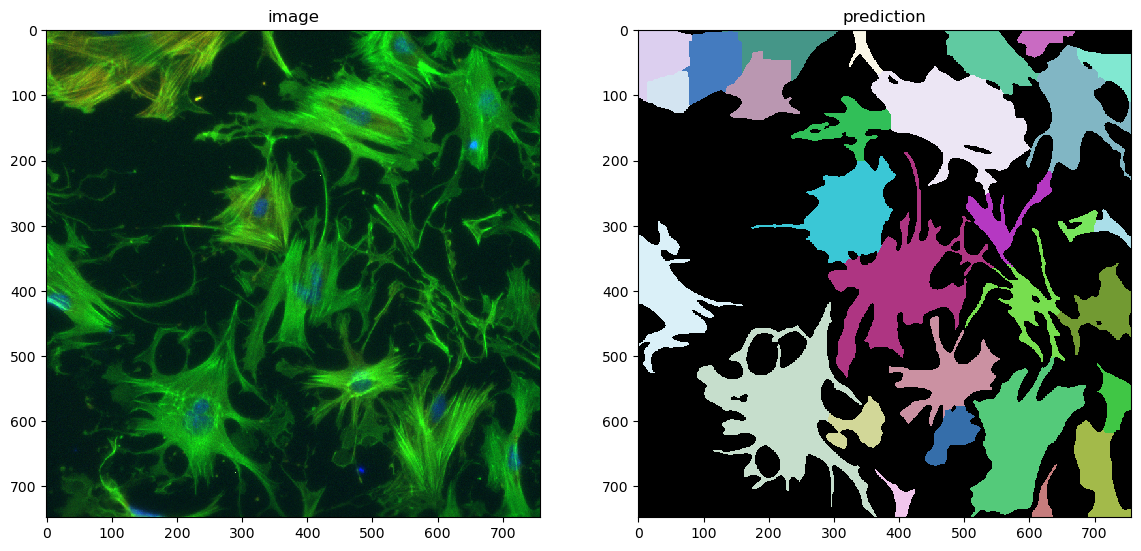

In [8]:
fig = imshow_multi2d([image//255, prediction], ['image', 'prediction'], 1, 2, 14, 7, colormaps=['gray', random_label_cmap()])

fig_path = os.path.join(parent_path, 'figures')

if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig_path = os.path.join(fig_path, 'automatic_instance_segmentation.png')
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

In [1]:
from tnia.deeplearning.dl_helper import quantile_normalization

image_n = quantile_normalization(image, channels=True).astype(np.float32)
print(image_n.shape)
image_n = (image_n / image_n.max() * 255).astype(np.uint8)
print(image_n.shape)
#image_n = np.transpose(image_n, (2, 0, 1))  # transpose to (H, W, C) format

# Step 2: Get the instance segmentation for the given image.
prediction = automatic_instance_segmentation(
    predictor=predictor,  # the predictor for the Segment Anything model.
    segmenter=segmenter,  # the segmenter class responsible for generating predictions.
    input_path=image_n,
    ndim=2,
    tile_shape=tile_shape,
    halo=halo,
    #foreground_threshold= 0.4, #0.4,  # threshold for foreground 
    #center_distance_threshold=0.6, # 0.3
)

print(prediction.sum())

fig = imshow_multi2d([image_n, prediction], ['image', 'prediction'], 1, 2, 14, 7, colormaps=['gray', random_label_cmap()])
fig.savefig(fig_path.replace('.png', '_normalized.png'), dpi=300, bbox_inches='tight')



NameError: name 'image' is not defined

Compute Image Embeddings 2D tiled: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]
Initialize tiled instance segmentation with decoder: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


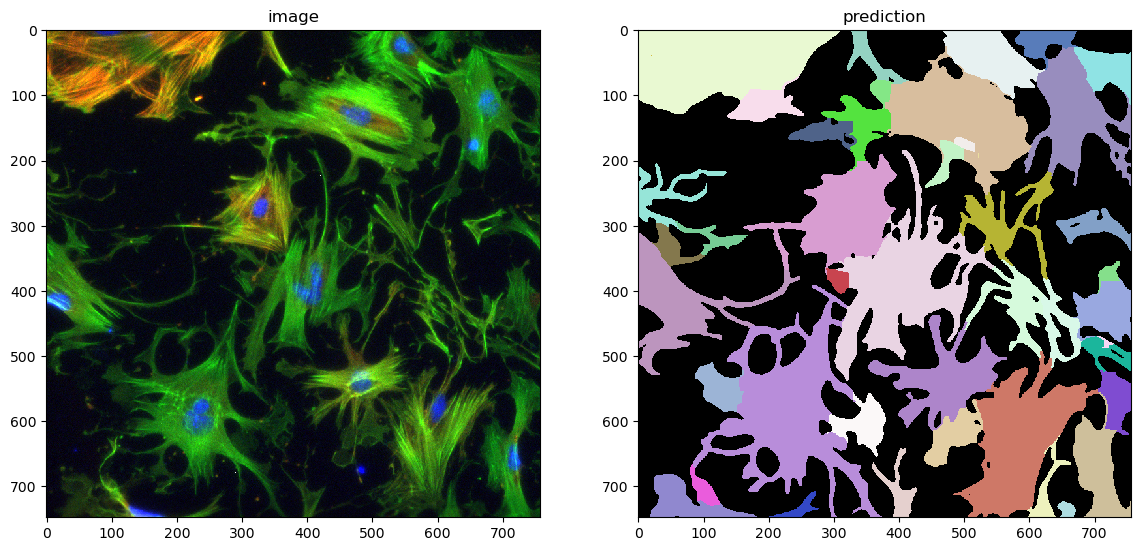

In [28]:

# Step 2: Get the instance segmentation for the given image.
prediction = automatic_instance_segmentation(
    predictor=predictor,  # the predictor for the Segment Anything model.
    segmenter=segmenter,  # the segmenter class responsible for generating predictions.
    input_path=image_n,
    ndim=2,
    tile_shape=tile_shape,
    halo=halo,
    foreground_threshold= 0.2, #0.4,  # threshold for foreground 
    center_distance_threshold=0.5, # 0.3
    boundary_distance_threshold=0.7,
)

fig = imshow_multi2d([image_n, prediction], ['image', 'prediction'], 1, 2, 14, 7, colormaps=['gray', random_label_cmap()])

fig.savefig(fig_path.replace('.png', '_normalized_foreground_threshold_0.3.png'), dpi=300, bbox_inches='tight')



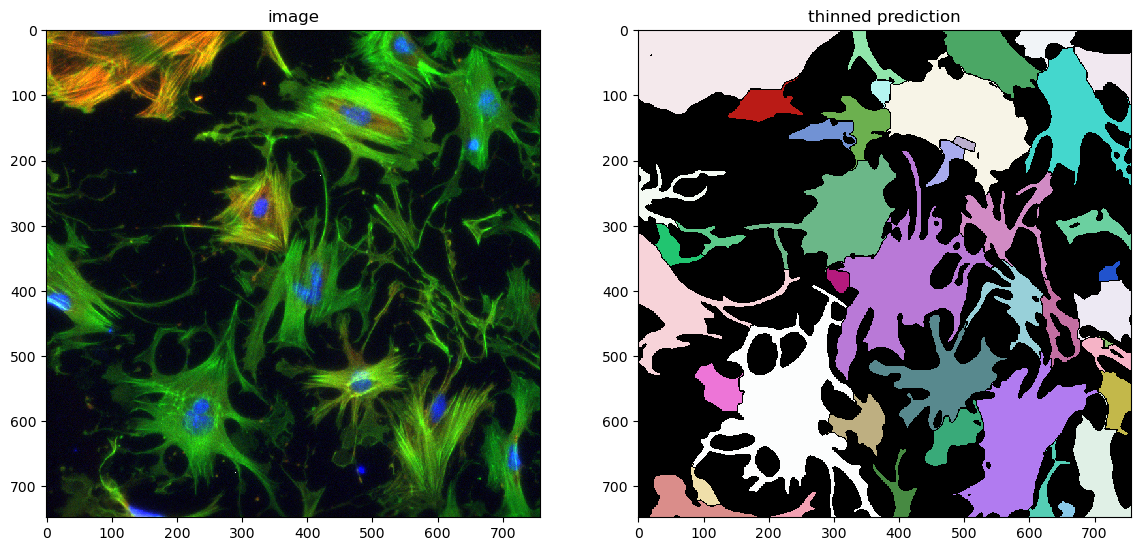

In [29]:
import numpy as np
from skimage import morphology, measure

def thin_labels(label_img, method='erosion', iterations=1):
    thinned = np.zeros_like(label_img)
    for region_label in np.unique(label_img):
        if region_label == 0:
            continue  # Skip background
        mask = label_img == region_label

        if method == 'erosion':
            thinned_mask = morphology.binary_erosion(mask)
        elif method == 'thin':
            thinned_mask = morphology.thin(mask)
        else:
            raise ValueError("Method must be 'erosion' or 'thin'.")

        thinned[thinned_mask] = region_label
    return thinned

# Apply thinning to the prediction
thinned_prediction = thin_labels(prediction, method='erosion', iterations=1)
fig = imshow_multi2d([image_n, thinned_prediction], ['image', 'thinned prediction'], 1, 2, 14, 7, colormaps=['gray', random_label_cmap()])
fig.savefig(fig_path.replace('.png', '_thinned_prediction.png'), dpi=300, bbox_inches='tight')






Compute Image Embeddings 2D tiled: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Initialize tiled instance segmentation with decoder: 100%|██████████| 4/4 [00:00<00:00, 11.68it/s]


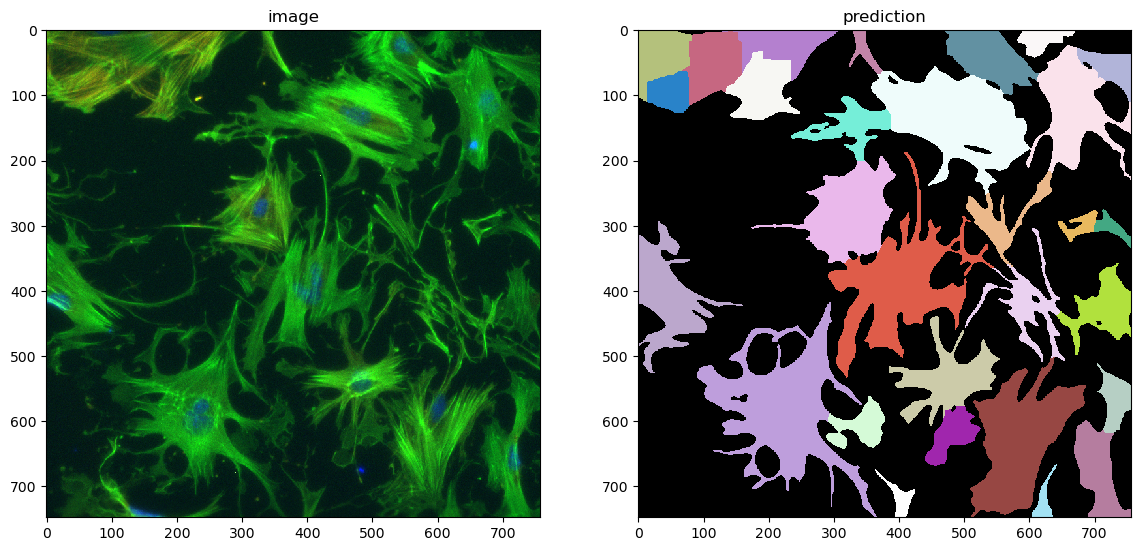

In [14]:

# Step 2: Get the instance segmentation for the given image.
prediction = automatic_instance_segmentation(
    predictor=predictor,  # the predictor for the Segment Anything model.
    segmenter=segmenter,  # the segmenter class responsible for generating predictions.
    input_path=image,
    ndim=2,
    tile_shape=tile_shape,
    halo=halo,
)

fig = imshow_multi2d([image//255, prediction], ['image', 'prediction'], 1, 2, 14, 7, colormaps=['gray', random_label_cmap()])



In [31]:
import napari

viewer = napari.Viewer()
viewer.add_image(image, name='image', colormap='gray')
viewer.add_labels(thinned_prediction, name='prediction')

<Labels layer 'prediction' at 0x18e73155e90>